<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_002_examples/_001_first_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# !unzip '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/train_job.zip' -d '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/'

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
data_dir_path = '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/'

In [158]:
import pandas as pd

def cp(s):
  return "{}{}".format(data_dir_path, s)

tags_df = pd.read_csv(cp('tags.csv'))
train_df = pd.read_csv(cp('train.csv'))
user_tag_df = pd.read_csv(cp('user_tags.csv'))
job_companies_df = pd.read_csv(cp('job_companies.csv'))
job_tag_df = pd.read_csv(cp('job_tags.csv'))

In [ ]:
tags_df.sample(5)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


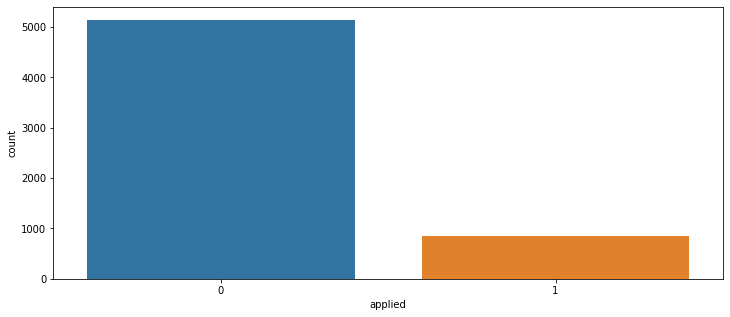

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.countplot(train_df['applied'])

In [ ]:
a = job_tag_df.groupby('jobID')
a.jobID.value_counts()

In [162]:
tags_df[tags_df['tagID'] == '8e2cfdc275761edc592f73a076197c33']['keyword'].values[0]

'Webpack'

In [163]:
def grouping_tags(df: pd.DataFrame, id: str) -> {}:
    result = []
    for u, t in df.groupby(id):
      temp = {}
      temp[id] = u
      temp['{}_tags'.format(id)] = " ".join(set(df[df[id] == u]['tagID'].apply(lambda x: tags_df[tags_df['tagID'] == x]['keyword'].values[0])))
      result.append(temp)

    return pd.DataFrame(result)

In [164]:
job_match_df = grouping_tags(job_tag_df, 'jobID')
job_match_df.head(2)

,jobID,jobID_tags
0,00ac8ed3b4327bdd4ebbebcb2ba10a00,Android Kotlin REST API RxJava Java Firebase Git
1,00e26af6ac3b1c1c49d7c3d79c60d000,Kotlin Android Python MySQL Angular C++ Angula...


In [165]:
user_match_df = grouping_tags(user_tag_df, 'userID')
user_match_df.sample(2)

,userID,userID_tags
100,847a7251b574c85da9c2248125c2df93,React Native
32,37b96469b46dfd9919cd984b788ceb17,MATLAB


# train 데이터에 job과 user tag 삽입

In [166]:
merge_user = pd.merge(train_df, user_match_df, how='left')
complete_merge = pd.merge(merge_user, job_match_df, how='left')

# 정규화 필요

In [ ]:
complete_merge[complete_merge['applied'] == 1]

In [67]:
# complete_merge['job_tags_split'] = complete_merge['jobID_tags'].apply(lambda x: x.split(","))
# complete_merge['user_tags_split'] = complete_merge['userID_tags'].apply(lambda x: x.split(","))

In [167]:
complete_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       6000 non-null   object
 1   jobID        6000 non-null   object
 2   applied      6000 non-null   int64 
 3   userID_tags  6000 non-null   object
 4   jobID_tags   6000 non-null   object
dtypes: int64(1), object(4)
memory usage: 281.2+ KB


## 첫 번째 시도



In [20]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(complete_merge['userID_tags'])
tag_sequences = tokenizer.texts_to_sequences(complete_merge['userID_tags'])
tag_vocab = tokenizer.word_index


tag_vocab
# tokenizer.texts_to_sequences()

## 두 번째 시도


In [168]:
df_fit = pd.concat([complete_merge['userID_tags'], complete_merge['jobID_tags']], ignore_index=True)

In [169]:
df_fit.shape

(12000,)

In [243]:
complete_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       6000 non-null   object
 1   jobID        6000 non-null   object
 2   applied      6000 non-null   int64 
 3   userID_tags  6000 non-null   object
 4   jobID_tags   6000 non-null   object
 5   job_tag      6000 non-null   object
 6   user_tag     6000 non-null   object
dtypes: int64(1), object(6)
memory usage: 375.0+ KB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=.0,
                             sublinear_tf=True)
vectorizer.fit(df_fit)
print(vectorizer.get_feature_names())
vocab = vectorizer.vocabulary_
# dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
# len(vectorizer.get_feature_names())

In [285]:
def trans(col):
  return np.array(vectorizer.transform([col]).toarray()).flatten()

In [286]:
complete_merge['job_tag'] = complete_merge['jobID_tags'].apply(trans)
complete_merge['user_tag'] = complete_merge['userID_tags'].apply(trans)

In [294]:
df_train = complete_merge.iloc[:, 5:7]

In [295]:
df_train['applied'] = pd.DataFrame(complete_merge.iloc[:, 2])

In [331]:
df_train

,job_tag,user_tag,applied
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.18501769278799826,...",0
...,...,...,...
5995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
5996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
5997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
5998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [236]:
df_train['sum'] = np.array(df_train['job_tag']) + np.array(df_train['user_tag'])
df_train['sum']


0       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.18501769278799826...
                              ...                        
5995    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5996    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5997    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5998    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5999    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: sum, Length: 6000, dtype: object

### 붓꽃 데이터로 LDA가 가능한 데이터 확인하기

In [148]:
from sklearn.datasets import load_iris

iris = load_iris()
iris.data.shape
iris.data[0]

array([5.1, 3.5, 1.4, 0.2])

In [ ]:
vectorizer.idf_

In [302]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

TEST_SIZE = .3
RANDOM_SEED = 33

train_input, test_input, train_label, test_label = train_test_split(df_train.iloc[:, :2],
                                                                   df_train['applied'],
                                                                   test_size=TEST_SIZE,
                                                                   random_state=RANDOM_SEED)



In [310]:
train_input

,job_tag,user_tag
4309,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3349,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2104477090746369, ..."
3515,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2439539473295602, ..."
3377,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.255...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
3273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5848,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 모델 구현 및 학습

In [ ]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(train_input, train_label)

In [307]:
X.shape

TensorShape([None, 3])

In [333]:
import tensorflow as tf

X = tf.keras.layers.Input(shape=[2])
H = tf.keras.layers.Flatten()(X)

H = tf.keras.layers.Dense(8)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(activation='swish')(H)

H = tf.keras.layers.Dense(3)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(activation='swish')(H)

Y = tf.keras.layers.Dense(1, activation='sigmoid')(H)

model = tf.keras.models.Model(X, Y)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accruacy'])

model.fit(df_train.iloc[:, :2],
          df_train['applied'], 
          epochs=100,
          batch_size=10)

ValueError: ignored

In [334]:
import tensorflow as tf
import pandas as pd

file_data = "https://raw.githubusercontent.com/blackdew/tensorflow1/master/csv/boston.csv"
data = pd.read_csv(file_data)

독립 =  data[['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']]
종속 = data[['medv']]

X = tf.keras.layers.Input(shape=[13])
Y = tf.keras.layers.Dense(1)(X)

model = tf.keras.models.Model(X, Y)

model.compile(loss='mse')
model.fit(독립, 종속, epochs=10000, verbose=0)

print(model.get_weights())

[array([[-0.09322948],
       [ 0.04667921],
       [-0.02279149],
       [ 2.6381185 ],
       [-1.8892272 ],
       [ 5.2390494 ],
       [-0.0103658 ],
       [-1.0597447 ],
       [ 0.2001502 ],
       [-0.01192027],
       [-0.52146834],
       [ 0.01189072],
       [-0.4627945 ]], dtype=float32), array([8.531473], dtype=float32)]


In [338]:
data.iloc[:1, 2]

0    2.31
Name: indus, dtype: float64